In [1]:
#import pandas, numpy, matplot, seaborn, warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# preprocessing
import re
import string
import itertools # for flattening
# nltk library
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer as wn
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
nltk.download('punkt', quiet=True)
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
# sklearn library
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#import gensim packages
import gensim
from gensim import models, interfaces, utils
from gensim.models import Nmf

In [7]:
#import NLTK lemmatization packages
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet

In [5]:
#read in the pickled file
new_df=pd.read_pickle('/content/sample_data/cleanedfile_dicejob.pickle')

In [6]:
new_df['jd_old']=new_df['jd_old'].drop_duplicates()

## Count vectorizer - Bigram

In [76]:
# from sklearn.feature_extraction.text import CountVectorizer


# # Create the count vectorizer object
# vectorizer = CountVectorizer()

# # Fit the vectorizer to the documents and transform them into a matrix
# matrix = vectorizer.fit_transform(new_df['joined_bigram'])

# # Get the feature names (the words or n-grams)
# feature_names = vectorizer.get_feature_names()

# # Convert the matrix to a dense array
# array = matrix.toarray()

# # Print the feature names and matrix
# print("Feature names:", feature_names)
# print("Matrix:")
# print(array)



## TDIDF vectorizer - Bigram

In [9]:
#TDIDF to vectorize the bigrammed job descriptions to get the vectorized bag of words. 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorized_col = new_df['joined_bigram']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(vectorized_col)
X_train

<20084x92530 sparse matrix of type '<class 'numpy.float64'>'
	with 2409337 stored elements in Compressed Sparse Row format>

## NLTK NMF

In [10]:
#Fit the X_traini nto NLTK NMF model. Set up n_components = 10. 
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

topic_model = NMF(n_components = 10)
topic_model.fit(X_train)

NMF(n_components=10)

In [11]:
#Populate H and W matrix for topics and words representation. 
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (10, 92530)
Shape of H is (20084, 10)
Shape of X_train is (20084, 92530)


In [12]:
#Generated topics. 

for index,topic in enumerate(W):
    print(f'THE TOP 25 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 25 WORDS FOR TOPIC #0
['knowledge', 'management', 'architecture', 'information', 'skill', 'provide', 'need', 'document', 'develop', 'technology', 'functional', 'ability', 'development', 'support', 'product', 'user', 'analysis', 'solution', 'design', 'process', 'system', 'analyst', 'technical', 'requirement', 'business']


THE TOP 25 WORDS FOR TOPIC #1
['engineer', 'mvc', 'work', 'strong', 'sql', 'service', 'ui', 'build', 'mobile', 'spring', 'develop', 'jquery', 'technology', 'use', 'code', 'framework', 'year', 'application', 'developer', 'software', 'javascript', 'design', 'development', 'web', 'java']


THE TOP 25 WORDS FOR TOPIC #2
['router_switch', 'equipment', 'voip', 'wan', 'knowledge', 'engineering', 'technology', 'vpn', 'networking', 'center', 'router', 'hardware', 'troubleshoot', 'rout', 'ip', 'voice', 'design', 'protocol', 'switch', 'wireless', 'infrastructure', 'firewall', 'engineer', 'cisco', 'network']


THE TOP 25 WORDS FOR TOPIC #3
['architect', 'python', 'use', '

#### Visualization

In [13]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 10})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 15
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Top Topics")

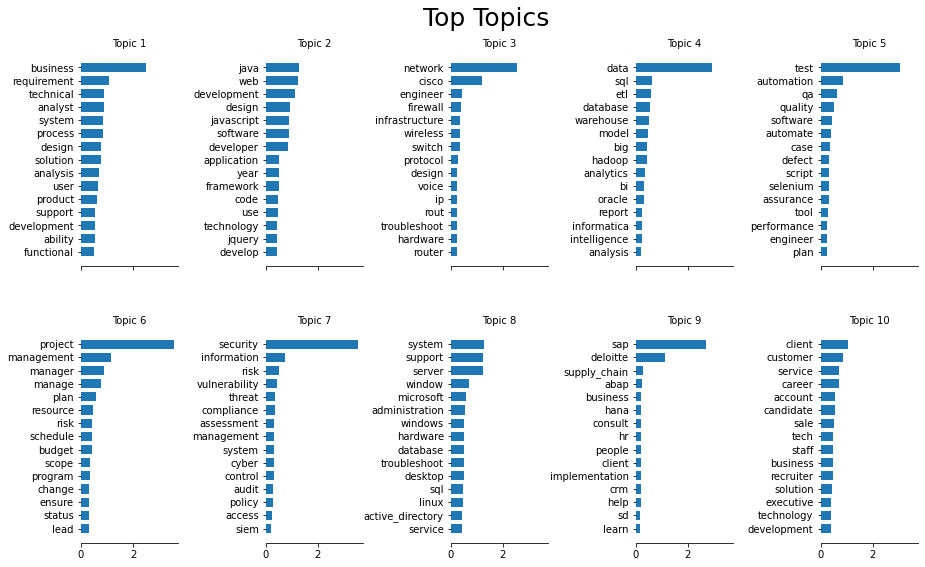

In [14]:
topic_word_plot()

In [15]:
topic_name_dict = {0: 'business_solution_analyst', 1: 'web_developer', 2: 'network_engineer', 3: 'data_reporting', 4: 'qa_automation_test',5:'project_management',6:'cyber_security',7:'system_support',8:'deloitte_sap',9:'customer_service'}

In [16]:
topic_keys = topic_name_dict.values()

In [17]:
list(zip(topic_name_dict.values(), list(H[2,:])))

[('business_solution_analyst', 0.026658294893480528),
 ('web_developer', 0.0),
 ('network_engineer', 0.0),
 ('data_reporting', 0.12108490118955031),
 ('qa_automation_test', 0.013789186290687906),
 ('project_management', 0.020930086945243526),
 ('cyber_security', 0.006990431800551396),
 ('system_support', 0.0),
 ('deloitte_sap', 0.0019409671235629724),
 ('customer_service', 0.009050214596417704)]

In [18]:
coefdistribution=pd.DataFrame(H, columns = topic_keys)
coefdistribution

,business_solution_analyst,web_developer,network_engineer,data_reporting,qa_automation_test,project_management,cyber_security,system_support,deloitte_sap,customer_service
0,0.002621,0.064387,0.018289,0.011938,0.073097,0.002775,0.000000,0.018134,0.009337,0.006401
1,0.000710,0.000000,0.007381,0.000000,0.001711,0.006068,0.154003,0.014359,0.001376,0.000889
2,0.026658,0.000000,0.000000,0.121085,0.013789,0.020930,0.006990,0.000000,0.001941,0.009050
3,0.008816,0.043820,0.001814,0.012789,0.002448,0.003432,0.000000,0.026403,0.002991,0.013892
4,0.000000,0.022570,0.010402,0.000000,0.014237,0.003132,0.002499,0.030919,0.003883,0.017354
...,...,...,...,...,...,...,...,...,...,...
20079,0.035068,0.041421,0.001684,0.000000,0.001939,0.014659,0.000000,0.000000,0.000000,0.000000
20080,0.000000,0.068678,0.000000,0.000523,0.000558,0.000184,0.000000,0.002247,0.000000,0.012768
20081,0.025405,0.004919,0.000504,0.023207,0.116187,0.017638,0.000000,0.038171,0.000000,0.005778
20082,0.007765,0.046225,0.001795,0.002916,0.022365,0.005462,0.000000,0.000000,0.002611,0.022025


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

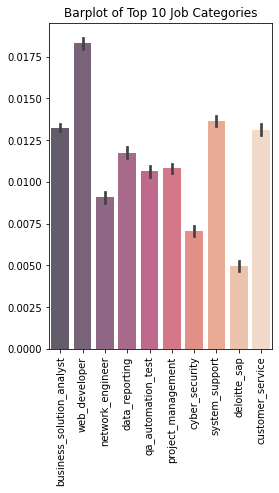

In [19]:
plt.figure(figsize=(4,6))
           
plt.title('Barplot of Top 10 Job Categories')

sns.barplot(data=coefdistribution, palette='rocket',alpha=.7)

plt.xticks(rotation=90)

In [25]:
#Generate TSNE graph to examine the clustering of the topics. 
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [26]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

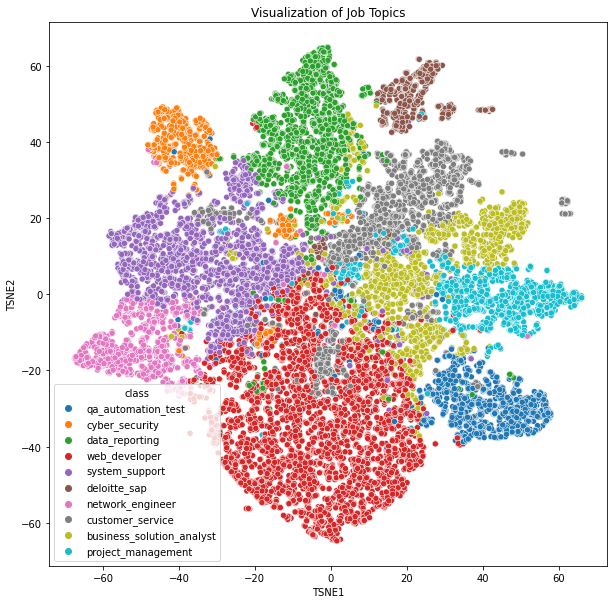

In [27]:

plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of Job Topics')
plt.show()

##### Recommendation System - NLTK NMF

In [78]:
#Create cosine recommendation system for recommending jobs based on the inpout
userinput=input()

data analytics, nmf, nlp


In [80]:
def input_process(text):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    txt_lower = text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    txt_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", txt_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    #remove words with short length
    
    # remove stop words and punctuations 
    txt_norm = [x for x in word_tokenize(txt_lower) if ((x.isalpha()) & (x not in stop_words)) & (x not in ['good','great','found','company','lot','experience','fit','candidate','applicant','requirement','qualification','Deloitte','professional','year','application','opportunity','description','work','role','need','email','delivery',"req_id","job_req","req","id","please","resume","position","forward","receive","contact","minimum","required","disability","eligibility","employment","team","click"])]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    txt_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(txt_norm))) 

    # lemmatize the input
    txt_processed = " ".join([wnl.lemmatize(x[0], x[1]) for x in txt_tagged if x[1] is not None])
    return txt_processed
    
    



In [81]:
#improt library for google colab
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [82]:
userresume=input_process(userinput)

In [83]:
#preprocess of the input message by transforming the input text into a vectorized matrix.
from sklearn.feature_extraction.text import TfidfVectorizer


resume_vec = vectorizer.transform([userresume])
resume_vec

<1x92530 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [84]:
#transform the input matrix to the tuned model. 
resume_transform=topic_model.transform(resume_vec)

In [86]:
#use cosine similarity to calculate the similarity of the original data and the vectorized resume.
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(X_train, resume_vec)


In [178]:
dic = {}
for i,x in enumerate(sim):
  dic[i] = x

In [269]:
#Place the results into a datafram

highest_sim = pd.DataFrame(dic).T.sort_values(by = 0, ascending = False).head(100).index


pd.DataFrame((new_df.iloc[highest_sim, :][['jobtitle','jobdescription',"company"]].values),columns=[["Job Title","Job Description","Company"]])

,Job Title,Job Description,Company
0,Manager HRIS/Payroll Systems and Operations,"HRIS systems, payroll systems Affinity Health ...",Affinity HealthPlan
1,Lead/Sr Data Scientist,"Machine Learning, Big Data, Java Title: Lead D...",BayOne Solutions
2,"Data Analytics, NJ","R, SAS, SQL, Python, statistical, visual analy...",Newt Global
3,"Sr. Data Scientist - Machine Learning, Python,...","Data Science, Predictive Analytics, Machine Le...",Precision Systems
4,Digital Data Management Lead,"data management, data governance, data archite...",Talus Partners
...,...,...,...
95,Data Engineer,"Data Science, Statistics, Data Analysis, Data ...",Rhode Island Quality Institute
96,QA,T-SQL scripts •Develop a set of Load Testing s...,Openarc
97,Data Architect,Experience in Data Management/ Data Architectu...,Reliable Software Resources
98,Data Developer,"data analysis, data loading, data transformati...","Symbioun Technologies, Inc"


## GENSIM LDA - Final model

In [26]:
import gensim

In [27]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

In [28]:
from gensim import corpora, models

In [29]:
dictionary = corpora.Dictionary(new_df['bigramtexts'])

In [30]:
corpus_gensimlda = [dictionary.doc2bow(word) for word in new_df['bigramtexts']]

In [ ]:
gensimldamodel = models.ldamodel.LdaModel(corpus_gensimlda, num_topics=10, id2word=dictionary, passes=200, random_state=1000)

In [191]:
print(gensimldamodel.print_topics(num_topics=10,num_words=5))

[(0, '0.029*"system" + 0.028*"support" + 0.016*"service" + 0.016*"server" + 0.012*"infrastructure"'), (1, '0.013*"solution" + 0.010*"include" + 0.010*"status" + 0.009*"tech" + 0.008*"information"'), (2, '0.043*"sql" + 0.041*"oracle" + 0.038*"database" + 0.033*"data" + 0.017*"server"'), (3, '0.027*"web" + 0.026*"design" + 0.024*"development" + 0.021*"java" + 0.016*"year"'), (4, '0.029*"sap" + 0.024*"business" + 0.023*"client" + 0.017*"sale" + 0.014*"service"'), (5, '0.052*"test" + 0.036*"software" + 0.027*"development" + 0.021*"design" + 0.017*"system"'), (6, '0.073*"security" + 0.059*"network" + 0.021*"cisco" + 0.015*"information" + 0.010*"technology"'), (7, '0.015*"client" + 0.013*"product" + 0.012*"technology" + 0.009*"service" + 0.008*"customer"'), (8, '0.029*"project" + 0.024*"business" + 0.018*"management" + 0.012*"technical" + 0.011*"process"'), (9, '0.161*"data" + 0.020*"big" + 0.018*"analytics" + 0.018*"hadoop" + 0.016*"model"')]


### PyLDAvis Visual

In [192]:
import pyLDAvis


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [193]:
import pyLDAvis.gensim_models

In [194]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(gensimldamodel,corpus_gensimlda,dictionary,mds='nmds',R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.081175 -0.034273       1        1  31.260093
7     -0.190080  0.124247       2        1  13.890370
3      0.076312  0.047579       3        1  10.789146
5      0.070464 -0.004972       4        1  10.419909
0     -0.008010 -0.157295       5        1  10.416952
1     -0.183905 -0.030541       6        1   6.968689
6      0.022168 -0.220315       7        1   4.570617
4     -0.161184  0.139057       8        1   4.568811
2      0.186881 -0.016139       9        1   4.403677
9      0.268529  0.152652      10        1   2.711734, topic_info=           Term          Freq         Total Category  logprob  loglift
37         data  26358.000000  26358.000000  Default  30.0000  30.0000
163        test  23517.000000  23517.000000  Default  29.0000  29.0000
259    security  14318.000000  14318.000000  Default  28.0000  28.0000
98      network  14254.000000  14254.000000  Default  27.0000  27.0000
281    business  36077.000000  36077.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
281    business    690.636127  36077.241562  Topic10  -4.9357  -0.3482
308  enterprise    541.250572   7783.148033  Topic10  -5.1794   0.9417
38     database    528.129702   8114.747053  Topic10  -5.2040   0.8755
153         sql    512.856229  10248.581912  Topic10  -5.2333   0.6127
86        learn    486.431293   4673.690570  Topic10  -5.2862   1.3450

[788 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7708      8  0.994789     abap
1         1  0.640916  ability
1         2  0.021622  ability
1         3  0.053531  ability
1         4  0.094565  ability
...     ...       ...      ...
184       6  0.052840     year
184       7  0.033674     year
184       8  0.029524     year
184       9  0.089329     year
184      10  0.024904     year

[1765 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 4, 6, 1, 2, 7, 5, 3, 10])

### Tuning - Coherence Model

In [195]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

In [196]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda=CoherenceModel(model=gensimldamodel,texts=new_df['bigramtexts'],dictionary=dictionary,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Socre: ',coherence_lda)


Coherence Socre:  0.4096666202610506


In [197]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [198]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_gensimlda, texts=new_df['bigramtexts'], start=35, limit=55, step=1)


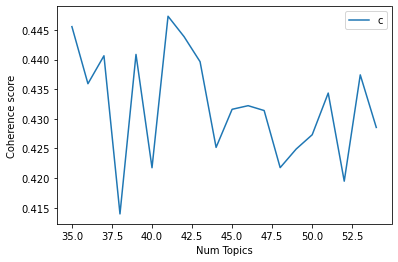

In [199]:
# Show graph
limit=55; start=35; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [200]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 35  has Coherence Value of 0.4456
Num Topics = 36  has Coherence Value of 0.4359
Num Topics = 37  has Coherence Value of 0.4406
Num Topics = 38  has Coherence Value of 0.414
Num Topics = 39  has Coherence Value of 0.4409
Num Topics = 40  has Coherence Value of 0.4217
Num Topics = 41  has Coherence Value of 0.4473
Num Topics = 42  has Coherence Value of 0.4439
Num Topics = 43  has Coherence Value of 0.4396
Num Topics = 44  has Coherence Value of 0.4252
Num Topics = 45  has Coherence Value of 0.4316
Num Topics = 46  has Coherence Value of 0.4322
Num Topics = 47  has Coherence Value of 0.4314
Num Topics = 48  has Coherence Value of 0.4218
Num Topics = 49  has Coherence Value of 0.4249
Num Topics = 50  has Coherence Value of 0.4273
Num Topics = 51  has Coherence Value of 0.4343
Num Topics = 52  has Coherence Value of 0.4195
Num Topics = 53  has Coherence Value of 0.4374
Num Topics = 54  has Coherence Value of 0.4285


In [213]:
optimal_model_glda = model_list[0]
model_topics = optimal_model_glda.show_topics(formatted=False)
optimal_model_glda.print_topics(num_words=10)

[(10,
  '0.058*"data" + 0.024*"report" + 0.022*"business" + 0.017*"analysis" + 0.015*"financial" + 0.011*"analyst" + 0.011*"sql" + 0.009*"excel" + 0.009*"skill" + 0.009*"process"'),
 (3,
  '0.021*"people" + 0.020*"know" + 0.019*"client" + 0.016*"business" + 0.016*"help" + 0.015*"consult" + 0.013*"consultant" + 0.012*"career" + 0.011*"make" + 0.011*"technology"'),
 (30,
  '0.061*"design" + 0.032*"mobile" + 0.020*"user" + 0.015*"io" + 0.014*"android" + 0.012*"designer" + 0.012*"ux" + 0.012*"product" + 0.012*"visual" + 0.011*"seo"'),
 (22,
  '0.041*"eg" + 0.025*"vital" + 0.023*"anyone" + 0.014*"solaris_aix" + 0.013*"federation" + 0.010*"max" + 0.010*"autosys" + 0.007*"network" + 0.006*"mo" + 0.005*"wireless"'),
 (2,
  '0.030*"system" + 0.023*"software" + 0.020*"test" + 0.019*"design" + 0.016*"development" + 0.011*"program" + 0.010*"requirement" + 0.009*"develop" + 0.009*"engineering" + 0.008*"technical"'),
 (17,
  '0.021*"apply" + 0.019*"look" + 0.017*"year" + 0.012*"verification" + 0.010

In [202]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(optimal_model_glda,corpus_gensimlda,dictionary,R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
28     0.136092  0.091107       1        1  10.933973
35     0.098348  0.110084       2        1   8.203381
38     0.142999 -0.099394       3        1   7.724652
4      0.125141  0.055981       4        1   5.801644
12     0.075882  0.087676       5        1   5.187343
21     0.103593 -0.140444       6        1   5.105671
19     0.062360 -0.041659       7        1   4.997417
2      0.110560  0.051817       8        1   4.802152
5      0.107557  0.086945       9        1   4.685831
25     0.097633 -0.050443      10        1   4.379691
16     0.095588 -0.030187      11        1   3.608820
29     0.098816 -0.054389      12        1   3.563520
10     0.104260  0.087984      13        1   3.114004
33     0.089829  0.061552      14        1   2.745859
18     0.048965  0.142743      15        1   2.362066
9      0.031549  0.065315      16        1   2.153356
17     0.007114 -0.181245      17        1   2.047406
0      0.073127  0.077216      18        1   1.911452
15     0.063918 -0.019929      19        1   1.759985
27     0.035756 -0.101508      20        1   1.652912
36    -0.081649  0.002187      21        1   1.527755
32     0.056894  0.021039      22        1   1.445798
20    -0.027967  0.022531      23        1   1.146207
30     0.017616 -0.123039      24        1   1.118409
6      0.004645  0.001783      25        1   0.989093
37     0.009117 -0.120557      26        1   0.985790
3     -0.020131 -0.070514      27        1   0.936478
1     -0.064577 -0.083401      28        1   0.921966
31    -0.034475  0.001342      29        1   0.832381
7     -0.035707 -0.090534      30        1   0.769634
14    -0.086093  0.079410      31        1   0.698597
26    -0.124639 -0.011131      32        1   0.369272
22    -0.161005  0.115022      33        1   0.345605
23    -0.158404  0.028745      34        1   0.300139
8     -0.083898 -0.042906      35        1   0.296182
11    -0.119863  0.030366      36        1   0.229059
13    -0.112818  0.020075      37        1   0.205057
34    -0.312587  0.011232      38        1   0.099197
24    -0.373549  0.009129      39        1   0.042245, topic_info=               Term          Freq         Total Category  logprob  loglift
163            test  24723.000000  24723.000000  Default  30.0000  30.0000
245         project  34025.000000  34025.000000  Default  29.0000  29.0000
259        security  16043.000000  16043.000000  Default  28.0000  28.0000
98          network  15179.000000  15179.000000  Default  27.0000  27.0000
40           design  28098.000000  28098.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
11161  localization      2.688887     55.904429  Topic39  -6.3223   4.7349
5529       register      2.064725     62.469723  Topic39  -6.5865   4.3597
8090         radius      1.975380     37.916577  Topic39  -6.6307   4.8148
159          system      2.414640  33767.414800  Topic39  -6.4299  -1.7763
7185            emc      2.115958    415.919410  Topic39  -6.5620   2.4885

[2909 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
0         12  0.960666  ab_initio
0         25  0.028677  ab_initio
7708       8  0.014118       abap
7708      15  0.003530       abap
7708      23  0.974164       abap
...      ...       ...        ...
5245      35  0.002395         yr
12720     38  0.744801        yum
4611      17  0.969971       zend
14117     11  0.970629  zookeeper
11148     29  0.940987        zos

[21694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[29, 36, 39, 5, 13, 22, 20, 3, 6, 26, 17, 30, 11, 34, 19, 10, 18, 1, 16, 28, 37, 33, 21, 31, 7, 38, 4, 2, 32, 8, 15, 27, 23, 24, 9, 12, 14, 35, 25])

## Gensim NMF Topic Modeling

In [20]:
from gensim import corpora, models, similarities

In [21]:
import gensim
from gensim import models, interfaces, utils
from gensim.models import Nmf

In [32]:
nmfmodel = gensim.models.nmf.Nmf(corpus_gensimlda, num_topics=10, id2word=dictionary)

In [33]:
print(nmfmodel.print_topics(num_topics=10,num_words=5))

[(0, '0.047*"system" + 0.032*"design" + 0.022*"software" + 0.021*"network" + 0.015*"engineering"'), (1, '0.132*"data" + 0.021*"database" + 0.019*"sql" + 0.015*"model" + 0.010*"year"'), (2, '0.086*"test" + 0.052*"security" + 0.019*"information" + 0.011*"quality" + 0.011*"risk"'), (3, '0.037*"support" + 0.021*"management" + 0.014*"include" + 0.013*"technical" + 0.011*"provide"'), (4, '0.051*"business" + 0.025*"solution" + 0.017*"data" + 0.016*"management" + 0.016*"technology"'), (5, '0.028*"product" + 0.017*"customer" + 0.016*"development" + 0.015*"client" + 0.012*"deloitte"'), (6, '0.032*"service" + 0.032*"security" + 0.025*"network" + 0.019*"customer" + 0.016*"skill"'), (7, '0.044*"system" + 0.033*"business" + 0.017*"test" + 0.015*"support" + 0.014*"skill"'), (8, '0.096*"project" + 0.025*"management" + 0.014*"manager" + 0.012*"plan" + 0.012*"manage"'), (9, '0.031*"development" + 0.019*"software" + 0.017*"web" + 0.015*"year" + 0.015*"design"')]


In [34]:
for topic_id, topic in nmfmodel.show_topics(formatted=False):
    print(f"Topic #{topic_id}: ", end='')
    print([(word, round(probability, 4)) for word, probability in topic])

Topic #0: [('system', 0.047), ('design', 0.0324), ('software', 0.0219), ('network', 0.0208), ('engineering', 0.0152), ('project', 0.0134), ('engineer', 0.0132), ('product', 0.0105), ('technology', 0.0102), ('technical', 0.0101)]
Topic #1: [('data', 0.1323), ('database', 0.0214), ('sql', 0.0188), ('model', 0.0146), ('year', 0.0097), ('warehouse', 0.0094), ('etl', 0.0094), ('big', 0.0091), ('use', 0.0086), ('report', 0.0079)]
Topic #2: [('test', 0.0863), ('security', 0.0525), ('information', 0.0193), ('quality', 0.0112), ('risk', 0.0107), ('automation', 0.0102), ('project', 0.0098), ('management', 0.0097), ('plan', 0.0084), ('system', 0.0075)]
Topic #3: [('support', 0.0365), ('management', 0.0207), ('include', 0.014), ('technical', 0.0134), ('provide', 0.0114), ('knowledge', 0.0099), ('ability', 0.0087), ('server', 0.0075), ('issue', 0.0074), ('customer', 0.0073)]
Topic #4: [('business', 0.051), ('solution', 0.0245), ('data', 0.0168), ('management', 0.0164), ('technology', 0.016), ('requ

### Visualization

In [35]:
pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.22.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2


In [36]:
from gensim import interfaces, utils, matutils

### Coherence Score Tuning

In [37]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_nmf=CoherenceModel(model=nmfmodel,texts=new_df['bigramtexts'],dictionary=dictionary,coherence='c_v')
coherence_nmf=coherence_model_nmf.get_coherence()
print('\nCoherence Socre: ',coherence_nmf)


Coherence Socre:  0.36658799383137736


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.nmf.Nmf(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_gensimlda, texts=new_df['bigramtexts'], start=35, limit=70, step=5)


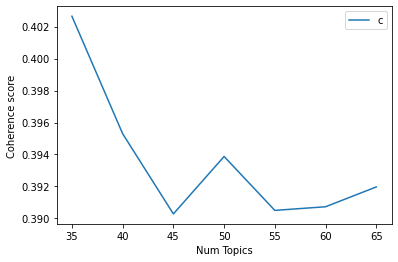

In [40]:
# Show graph
limit=70; start=35; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 35  has Coherence Value of 0.4026
Num Topics = 40  has Coherence Value of 0.3953
Num Topics = 45  has Coherence Value of 0.3903
Num Topics = 50  has Coherence Value of 0.3939
Num Topics = 55  has Coherence Value of 0.3905
Num Topics = 60  has Coherence Value of 0.3907
Num Topics = 65  has Coherence Value of 0.392


In [44]:
optimal_model_nmfgensim = model_list[0]
model_topics = optimal_model_nmfgensim.show_topics(formatted=False)
optimal_model_nmfgensim.print_topics(num_words=10)

[(2,
  '0.018*"information" + 0.013*"client" + 0.012*"provide" + 0.011*"candidate" + 0.008*"apply" + 0.007*"staff" + 0.007*"contract" + 0.007*"include" + 0.006*"employee" + 0.006*"look"'),
 (4,
  '0.079*"oracle" + 0.041*"java" + 0.037*"client" + 0.021*"sql" + 0.016*"spring" + 0.016*"management" + 0.008*"soap" + 0.008*"soa_fusion" + 0.008*"middleware_bpel" + 0.008*"eai_esb"'),
 (7,
  '0.016*"use" + 0.016*"server" + 0.016*"strong" + 0.016*"build" + 0.016*"tool" + 0.015*"knowledge" + 0.015*"ability" + 0.014*"aws" + 0.014*"customer" + 0.014*"sql"'),
 (8,
  '0.062*"web" + 0.035*"developer" + 0.027*"development" + 0.027*"javascript" + 0.021*"java" + 0.020*"year" + 0.019*"application" + 0.013*"use" + 0.012*"framework" + 0.012*"develop"'),
 (9,
  '0.077*"software" + 0.036*"java" + 0.024*"engineer" + 0.021*"technology" + 0.020*"development" + 0.019*"build" + 0.016*"year" + 0.012*"computer" + 0.011*"science" + 0.010*"developer"'),
 (34,
  '0.039*"engineering" + 0.026*"program" + 0.017*"team" + 0

# NLTK LDA

In [51]:
nltklda = models.LdaModel(corpus_gensimlda, num_topics=10, id2word=dictionary, passes=10)

In [52]:
for topic in nltklda.show_topics(num_topics=10, num_words=10):
    print(topic)

(0, '0.019*"system" + 0.019*"design" + 0.017*"engineering" + 0.012*"software" + 0.011*"engineer" + 0.010*"status" + 0.009*"equipment" + 0.008*"include" + 0.007*"test" + 0.007*"age"')
(1, '0.028*"product" + 0.023*"customer" + 0.018*"sale" + 0.017*"business" + 0.012*"service" + 0.011*"marketing" + 0.010*"new" + 0.009*"development" + 0.009*"client" + 0.009*"skill"')
(2, '0.031*"development" + 0.023*"software" + 0.022*"design" + 0.021*"web" + 0.018*"java" + 0.014*"year" + 0.013*"developer" + 0.011*"technology" + 0.011*"use" + 0.011*"service"')
(3, '0.071*"test" + 0.022*"automation" + 0.020*"cloud" + 0.020*"tool" + 0.016*"engineer" + 0.015*"system" + 0.015*"software" + 0.014*"script" + 0.014*"python" + 0.012*"build"')
(4, '0.020*"client" + 0.016*"look" + 0.015*"contract" + 0.014*"year" + 0.014*"apply" + 0.011*"candidate" + 0.010*"send" + 0.010*"month" + 0.010*"location" + 0.009*"hire"')
(5, '0.029*"network" + 0.025*"security" + 0.022*"system" + 0.021*"support" + 0.012*"service" + 0.011*"ser

In [54]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_nltklda=CoherenceModel(model=nltklda,texts=new_df['bigramtexts'],dictionary=dictionary,coherence='c_v')
coherence_nltklda=coherence_model_nltklda.get_coherence()
print('\nCoherence Socre: ',coherence_nltklda)


Coherence Socre:  0.42454865893077515


In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=40, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_gensimlda, texts=new_df['bigramtexts'], start=40, limit=60, step=5)


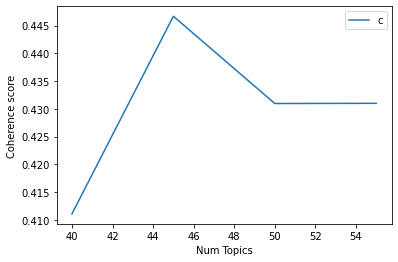

In [57]:
# Show graph
limit=60; start=40; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 40  has Coherence Value of 0.4111
Num Topics = 45  has Coherence Value of 0.4467
Num Topics = 50  has Coherence Value of 0.431
Num Topics = 55  has Coherence Value of 0.431


In [59]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics()

[(3,
  '0.026*"architecture" + 0.024*"technology" + 0.023*"solution" + 0.021*"architect" + 0.017*"data" + 0.016*"technical" + 0.015*"enterprise" + 0.014*"system" + 0.012*"business" + 0.012*"year"'),
 (33,
  '0.250*"security" + 0.027*"network" + 0.024*"threat" + 0.019*"cyber" + 0.018*"information" + 0.015*"vulnerability" + 0.011*"analysis" + 0.010*"firewall" + 0.010*"assessment" + 0.009*"event"'),
 (47,
  '0.069*"order" + 0.063*"purchase" + 0.040*"mdm" + 0.027*"supplier" + 0.019*"inventory" + 0.012*"data" + 0.012*"medicine" + 0.012*"informatics" + 0.010*"price" + 0.008*"vs"'),
 (13,
  '0.035*"candidate" + 0.023*"consultant" + 0.020*"recruiter" + 0.017*"interview" + 0.016*"apply" + 0.016*"year" + 0.015*"look" + 0.015*"get" + 0.015*"salesforce" + 0.014*"someone"'),
 (17,
  '0.023*"splunk" + 0.022*"security" + 0.019*"data" + 0.018*"mountain_view" + 0.010*"year" + 0.010*"tool" + 0.009*"design" + 0.008*"include" + 0.008*"knowledge" + 0.008*"system"'),
 (23,
  '0.047*"supply_chain" + 0.029*"d

In [60]:
len(model_topics)

10

# Recommendation System

In [62]:
from sklearn.metrics.pairwise import cosine_similarity

In [114]:
userinput=input()


data analytics, data, python, sql, nlp


In [115]:
def input_process(text):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    txt_lower = text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    txt_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", txt_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    #remove words with short length
    
    # remove stop words and punctuations 
    txt_norm = [x for x in word_tokenize(txt_lower) if ((x.isalpha()) & (x not in stop_words)) & (x not in ['good','great','found','company','lot','experience','fit','candidate','applicant','requirement','qualification','Deloitte','professional','year','application','opportunity','description','work','role','need','email','delivery',"req_id","job_req","req","id","please","resume","position","forward","receive","contact","minimum","required","disability","eligibility","employment","team","click"])]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    txt_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(txt_norm))) 

    # lemmatize the input
    txt_processed = [wnl.lemmatize(x[0], x[1]) for x in txt_tagged if x[1] is not None]
    return txt_processed
    
    



In [116]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [118]:
userresume=input_process(userinput)

In [119]:
# Build the bigram and trigram models
bigramed_user = gensim.models.Phrases(userresume, threshold=50) # higher threshold fewer phrases.
bigram_modtext_user = gensim.models.phrases.Phraser(bigramed_user)


In [120]:
import gensim
from gensim import corpora, models

In [121]:
dictionary_user = corpora.Dictionary([userresume])

In [122]:
resume_corpus = dictionary_user.doc2bow(userresume)

unigram test

In [71]:
dictionary_resume_unigram = corpora.Dictionary([userresume])
unigram_resume_corpus = dictionary_resume_unigram.doc2bow(userresume)

Based on Parveen's code:

In [72]:
from gensim.similarities import MatrixSimilarity

In [88]:
#fit tuned model to job description corpus
original_data = nmfmodel[corpus_gensimlda]

In [89]:
#apply similairties matrix to job description matrix
original_data_index = similarities.MatrixSimilarity(original_data)

In [123]:
#fit tuned model to resume corpus
resume_matrix=nmfmodel[unigram_resume_corpus]

In [124]:
sims = original_data_index[resume_matrix]

In [125]:
#create a series to list out the matrix
sorted_val_df = pd.Series(sims).sort_values(ascending = False).to_frame(name = "similarity")

In [126]:
sorted_val_df['name'] = new_df.iloc[sorted_val_df.index].uniq_id.values

In [127]:
jobtitle_recommend=sorted_val_df.name[0: 20]

In [128]:
jobs_recommended=new_df[new_df['uniq_id'].isin(jobtitle_recommend)]

In [129]:
jobs_recommended.jobtitle.values

array(['AUTOMATION TEST ENGINEER', 'Java Developer - Lead',
       'Senior Linux Engineer', 'Accountant',
       'Distributed WebSphere MQ Engineer', 'UI Developer',
       'Planning Analyst', 'SAP Automation/Worksoft Test Consultant',
       'Business Systems Analyst', 'Network Engineer',
       'Selenium QA Tester', 'Java Developer', 'ServiceNow Administrator',
       'SCCM Engineer', 'Front End Web UI Developer', 'SQL Developer',
       'IT Software QA Advisor', 'Front End Developer',
       'Design Engineer 0396', 'Large Systems Architect'], dtype=object)

In [110]:
# def recommend_from_text(self, text, num_rec = 10):
#   tokenized = self.tokenize_text(text)        
#   bow_vec = self.dictionary.doc2bow(tokenized)        
#   sims = self.index_sim[self.scotch_topic_model[bow_vec]]
#   sorted_val_df = pd.Series(sims).sort_values(ascending = False).to_frame(name = "similarity")
#   sorted_val_df['name'] = self.full_data.iloc[sorted_val_df.index].name.values
#   return sorted_val_df.name[0: num_rec]
